In [5]:
import numpy as np
import os
import gcsfs
import fsspec
import json
import xarray as xr
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import zarr
from tqdm.notebook import trange, tqdm
from dask.distributed import performance_report
import matplotlib.pyplot as plt

In [6]:
# load relevant data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101 = reload("A101").isel(attenuator_setting_pair=1)
ds_101_w = reload_winter("A101").isel(attenuator_setting_pair=1)
#ds_101 = xr.concat([ds_101,ds_101_w],'time')
ds_101.nbytes/1e9

88.146688964

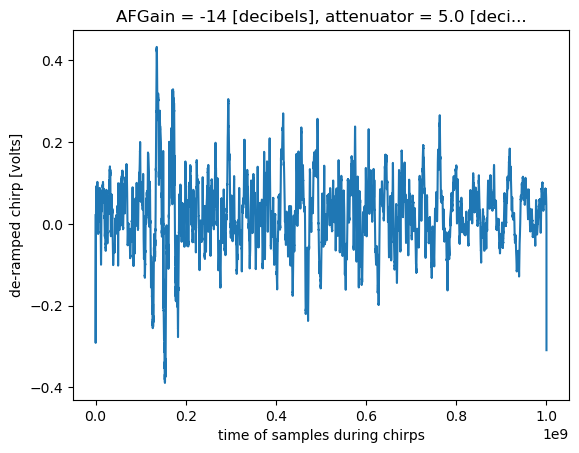

In [7]:
ds_101.chirp.isel(time=100, chirp_num=10).plot()

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[timedelta64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>)

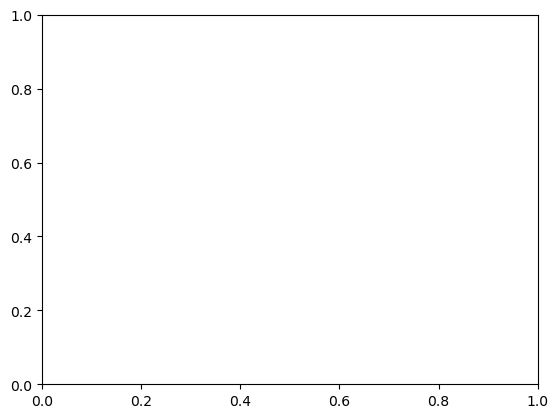

In [8]:
ds_101.chirp.isel(time=100).plot()

In [6]:
xa = ApRESDefs.xapres(max_range=1400)
dat_file_list = xa.list_files(directory=f'gs://ldeo-glaciology/GL_apres_2022/A103/summer_23', 
            remote_load = True)
#dat_file_list = [k for k in dat_file_list if folder in k] # this line filters to a subfolder

with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)


directory=f"gs://ldeo-glaciology/GL_apres_2022/A103/summer_23'"

In [35]:
count = 0
file_list = []
for file in tqdm(dat_file_list,):
    count +=1 
    if count == len(dat_file_list)-1:
        file_list.append(file)


  0%|          | 0/755 [00:00<?, ?it/s]

In [37]:
file_list

['ldeo-glaciology/GL_apres_2022/A103/summer_23/DIR2023-05-19-1524/DATA2023-08-31-0904.DAT']

In [38]:
 xa.load_all(directory, 
                remote_load = True,
                file_names_to_process=file_list)

In [39]:
xa.data

<xarray.Dataset>
Dimensions:          (time: 63, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 3, profile_range: 6658)
Coordinates:
  * time             (time) datetime64[ns] 2023-08-31T09:06:31 ... 2023-08-31...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    filename         (time) <U87 'ldeo-glaciology/GL_apres_2022/A103/summer_2...
    burst_number     (time) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62
    AFGain           (attenuator_setting_pair) int64 -4 -14 6
    attenuator       (attenuator_setting_pair) float64 10.0 5.0 15.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 68.74 68.74 68.74 ... 68.74 68.74 68.74
    longitude        (time) float64 -49.5 -49.5 -49.5 ... -49.5 -49.5 -49.5
    battery_voltage  (time) float64 12.48 12.47 12.47 ... 13.33 13.33 13.33
    temperature_1    (time) float64 27.24 27.24 27.24 ... 32.34 24.89 25.87
    temperature_2    (time) float64 26.15 26.15 26.54 26.34 ... 24.59 28.3 25.95

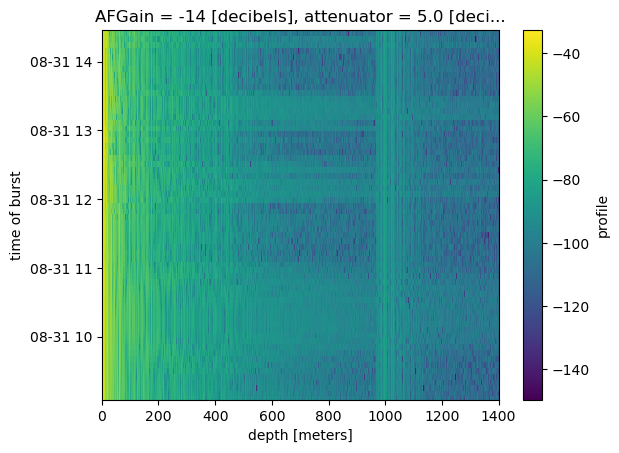

In [41]:
xa.dB(xa.data.isel(attenuator_setting_pair=1).profile.mean(dim='chirp_num')).plot()